In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/Shareddrives/my_workspace/uet/ImageProcessing

/content/drive/Shareddrives/my_workspace/uet/ImageProcessing


#Utils


In [17]:
def visualize(rows, cols, images, labels):
    fig = plt.figure(figsize=(10, 7))
    for i in range(len(images)):
        fig.add_subplot(rows, cols, i + 1)
        plt.imshow(images[i], cmap='gray', vmin=0, vmax=255)
        plt.axis('off')
        plt.title(labels[i])

In [36]:
def gaussian_discriminating_func(roi, x_nm, delta):
    output = np.zeros_like(roi, dtype="float32")
    h, w = roi.shape[:2]
    for i in np.arange(h):
        for j in np.arange(w):
             output[i][j] = math.exp(-(float(roi[i][j]) - float(x_nm))**2 / float(delta)**2)
    return output

def exponential_discriminating_func(roi, x_nm, delta):
    output = np.zeros_like(roi, dtype="float32")
    h, w = roi.shape[:2]
    for i in np.arange(h):
        for j in np.arange(w):
            output[i][j] = math.exp(-(abs(float(roi[i][j]) - float(x_nm)) / float(delta)))
    return output

# Robust nonlinear contrast enhancement

In [10]:
import numpy as np
import argparse
import math
import cv2

from scipy import signal
from skimage import color
from matplotlib import pyplot as plt
from skimage.exposure import rescale_intensity
from google.colab.patches import cv2_imshow

In [22]:
boat = cv2.imread("boat.png")
boatGray = cv2.cvtColor(boat, cv2.COLOR_BGR2GRAY)
girl = cv2.imread("girl.png")
girlGray = cv2.cvtColor(girl, cv2.COLOR_BGR2GRAY)

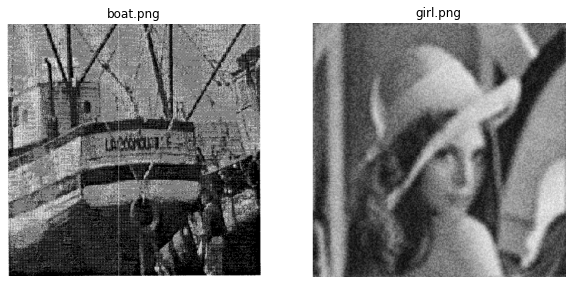

In [23]:
visualize(1, 2, [boat, girl], ['boat.png', 'girl.png'])

## Convolution

In [6]:
def convolve(image, kernel):
	# grab the spatial dimensions of the image, along with
	# the spatial dimensions of the kernel
    (iH, iW) = image.shape[:2]
    (kH, kW) = kernel.shape[:2]

	# allocate memory for the output image, taking care to
	# "pad" the borders of the input image so the spatial
	# size (i.e., width and height) are not reduced
    
    pad = (kW - 1) // 2
    image = cv2.copyMakeBorder(image, pad, pad, pad, pad, cv2.BORDER_REPLICATE)
    output = np.zeros((iH, iW), dtype="float32")
 
    # loop over the input image, "sliding" the kernel across
	# each (x, y)-coordinate from left-to-right and top to bottom
    for y in np.arange(pad, iH + pad):    	
        for x in np.arange(pad, iW + pad):
            # extract the ROI of the image by extracting the
            # *center* region of the current (x, y)-coordinates
            # dimentions
            roi = image[y - pad:y + pad + 1, x - pad:x + pad + 1]
            
            # perform the actual convolution by taking the 
            # element-wise multiplicate between the ROI and
            # the kernel, then summing the matrix
            k = (roi * kernel).sum()

            # store the convolved value in the output (x,y)-
            # coordinate of the output image
            output[y - pad, x - pad] = k
        
    
	# rescale the output image to be in the range [0, 255]
    output = rescale_intensity(output, in_range=(0, 255))
    output = (output * 255).astype("uint8")
    # return the output image
    return output


In [7]:
# construct the Laplacian kernel used to detect edge-like
# regions of an image
laplacian = np.array((
	[0, 1, 0],
	[1, -4, 1],
	[0, 1, 0]), dtype="int")
# construct the Sobel x-axis kernel
sobelX = np.array((
	[-1, 0, 1],
	[-2, 0, 2],
	[-1, 0, 1]), dtype="int")
# construct the Sobel y-axis kernel
sobelY = np.array((
	[-1, -2, -1],
	[0, 0, 0],
	[1, 2, 1]), dtype="int")


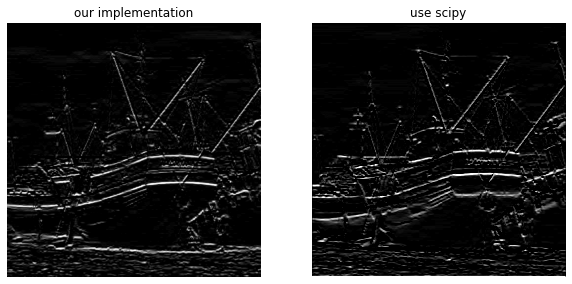

In [18]:
out = convolve(imgGray, sobelY)
out2 = signal.convolve2d(imgGray, sobelY)
visualize(1, 2, [out, out2], ['our implementation', 'use scipy'])

## Gradient like enhancement (GLE)

In [34]:
class GLE:
    def __init__(self, alpha=50, delta=40, get_weight=gaussian_discriminating_func):
        super().__init__()
        self.delta = delta
        self.alpha = alpha
        self.get_weight = get_weight

    def low_pass_filter(self, roi, weight):
        tmp = roi * weight
        return tmp.sum() / weight.sum() 

    def high_pass_filter(self, roi, weight):
        overline_m = weight.mean()
        delta_weight = weight - overline_m
        tmp = (weight - overline_m) * roi
        return tmp.sum()
    
    def __call__(self, image, kernel):
        (iH, iW) = image.shape[:2]
        (kH, kW) = kernel

        pad = (kW - 1) // 2
        image = cv2.copyMakeBorder(image, pad, pad, pad, pad, cv2.BORDER_REPLICATE)
        output = np.zeros((iH, iW), dtype="float32")
        for y in np.arange(pad, iH + pad):    	        
            for x in np.arange(pad, iW + pad):
                roi = image[y - pad:y + pad + 1, x - pad:x + pad + 1]
                weight = self.get_weight(roi, image[y][x], self.delta) # m_{i,j}
                y_L = self.low_pass_filter(roi, weight)
                y_H = self.high_pass_filter(roi, weight)
                output[y - pad][x - pad] = y_L + (y_L * y_H / self.alpha)

        # rescale the output image to be in the range [0, 255]
        output = rescale_intensity(output, in_range=(0, 255))
        output = (output * 255).astype("uint8")
        # return the output image
        return output

# Laplacian like enhancement (LLE)

In [56]:
class LLE:
    def __init__(self, alpha=50, delta=40, get_weight=gaussian_discriminating_func):
        super().__init__()
        self.delta = delta
        self.alpha = alpha
        self.get_weight = get_weight

    def low_pass_filter(self, roi, weight):
        tmp = roi * weight
        return tmp.sum() / weight.sum() 

    def high_pass_filter(self, roi, weight, x_nm):
        overline_m = weight.mean()
        # delta_weight = weight - overline_m
        tmp = (abs(weight - overline_m) * x_nm).sum() - (abs(weight - overline_m) * roi).sum()
        return tmp
    
    def __call__(self, image, kernel):
        (iH, iW) = image.shape[:2]
        (kH, kW) = kernel

        pad = (kW - 1) // 2
        image = cv2.copyMakeBorder(image, pad, pad, pad, pad, cv2.BORDER_REPLICATE)
        output = np.zeros((iH, iW), dtype="float32")
        for y in np.arange(pad, iH + pad):    	        
            for x in np.arange(pad, iW + pad):
                roi = image[y - pad:y + pad + 1, x - pad:x + pad + 1]
                weight = self.get_weight(roi, image[y][x], self.delta) # m_{i,j}
                y_L = self.low_pass_filter(roi, weight)
                y_H = self.high_pass_filter(roi, weight, image[y][x])
                output[y - pad][x - pad] = y_L + (y_L * y_H / self.alpha)

        # rescale the output image to be in the range [0, 255]
        output = rescale_intensity(output, in_range=(0, 255))
        output = (output * 255).astype("uint8")
        # return the output image
        return output

#Visualization

In [46]:
gle_filter = GLE()
smooth = cv2.GaussianBlur(boatGray, (95,95), 0)
division = cv2.divide(boatGray, smooth, scale=255)
gle_w_smooth = gle_filter(division, (3,3))
gle = gle_filter(boatGray, (3, 3))
# visualize(1, 3, [boatGray, gle_w_smooth, gle], ['origin', 'GLE with smooth', 'GLE'])

In [57]:
lle_filter = LLE()
smooth = cv2.GaussianBlur(boatGray, (95,95), 0)
division = cv2.divide(boatGray, smooth, scale=255)
lle_w_smooth = lle_filter(division, (3,3))
lle = gle_filter(boatGray, (3, 3))
# visualize(1, 3, [boatGray, lle_w_smooth, lle], ['origin', 'LLE with smooth', 'LLE'])

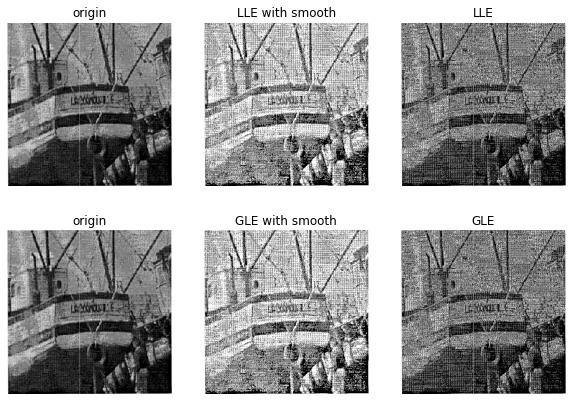

In [48]:
visualize(2, 3, [boatGray, lle_w_smooth, lle, boatGray, gle_w_smooth, gle], ['origin', 'LLE with smooth', 'LLE', 'origin', 'GLE with smooth', 'GLE'])

In [49]:
gle_filter = GLE()
smooth = cv2.GaussianBlur(girlGray, (95,95), 0)
division = cv2.divide(girlGray, smooth, scale=255)
gle_w_smooth = gle_filter(division, (3,3))
gle = gle_filter(girlGray, (3, 3))

In [50]:
lle_filter = LLE()
smooth = cv2.GaussianBlur(girlGray, (95,95), 0)
division = cv2.divide(girlGray, smooth, scale=255)
lle_w_smooth = lle_filter(division, (3,3))
lle = gle_filter(girlGray, (3, 3))

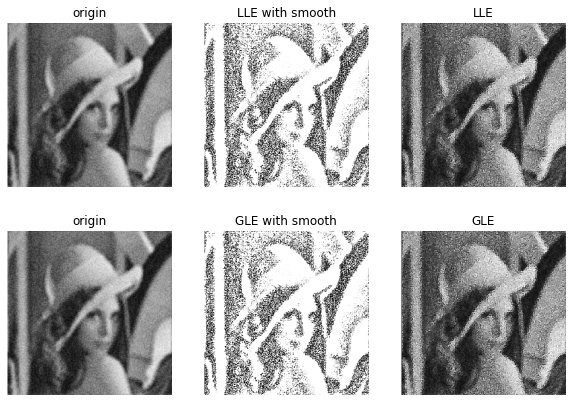

In [51]:
visualize(2, 3, [girlGray, lle_w_smooth, lle, girlGray, gle_w_smooth, gle], ['origin', 'LLE with smooth', 'LLE', 'origin', 'GLE with smooth', 'GLE'])